
# TensorFlow Implementation for Emotion Classification



## Configuration


In [ ]:

import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import cv2
import os
import sys
import re
import json
from ftfy import fix_text
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, Embedding, LSTM, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Concatenate, Lambda, MultiHeadAttention, Add, LayerNormalization, Reshape, TextVectorization
import random








In [6]:


BATCH_SIZE_MULTIMODAL = 1024
NUM_EPOCHS_MULTIMODAL = 12
LEARNING_RATE_MULTIMODAL = 5e-4

BATCH_SIZE_IMAGE = 48
NUM_EPOCHS_IMAGE = 12
LEARNING_RATE_IMAGE = 5e-4

BATCH_SIZE_TEXT = 1024
NUM_EPOCHS_TEXT = 30
LEARNING_RATE_TEXT = 1e-3
MAX_WORDS = 10000  
MAX_SEQUENCE_LENGTH = 100  

NUM_CLASSES = 7  # Neutral, Joy, Sadness, Anger, Surprise, Fear, Disgust
IMAGE_SIZE = (128, 128)
IMAGE_INPUT_SHAPE = (128, 128, 3)



TRAIN_VAL_IMAGES = 'Data/train_val'
TEST_IMAGES = 'Data/test'

TEXTS = 'Data/emotions.csv'

TRAIN_VAL_MULTIMODAL_IMAGES = 'Data/train_val_multimodal'
TEST_MULTIMODAL_IMAGES = 'Data/test_multimodal'

TRAIN_VAL_MULTIMODAL_CSV = 'Data/train_val_multimodal.csv'
TEST_MULTIMODAL_CSV = 'Data/test_multimodal.csv'

VECTORIZER = TextVectorization(max_tokens=MAX_WORDS, output_sequence_length=MAX_SEQUENCE_LENGTH)
df = pd.read_csv(TEXTS)
texts = df["text"].values
VECTORIZER.adapt(texts)





## Mapping for Emotions


In [2]:

# Mapping for emotions
EMOTION_MAP = {
    "anger": 0,
    "disgust": 1,
    "sadness": 2,
    "joy": 3,
    "neutral": 4,
    "fear": 5,
    "surprise": 6
}


EMOTION_MAP_TEXT = {
    "sadness": 0,
    "joy": 1,
    "love": 2,
    "anger": 3,
    "fear": 4,
    "surprise": 5
}


## Create Image Dataset


In [7]:
train_val_image_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_VAL_IMAGES,
    image_size=IMAGE_SIZE,  # Resize images if needed
    batch_size=BATCH_SIZE_IMAGE,
    shuffle=True
)

# Split the dataset into train and validation
train_size = int(0.8 * len(train_val_image_dataset))
train_image_dataset = train_val_image_dataset.take(train_size)
val_image_dataset = train_val_image_dataset.skip(train_size)


test_image_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_IMAGES,
    image_size=IMAGE_SIZE,  # Resize images if needed
    batch_size=BATCH_SIZE_IMAGE,
    shuffle=True
)


Found 58020 files belonging to 7 classes.
Found 9869 files belonging to 7 classes.



## Create Text Dataset


In [17]:
def create_text_dataset(csv_path, text_column, label_column, 
                        max_words, max_sequence_length, num_classes, batch_size,vectorizer=VECTORIZER):
   
    df = pd.read_csv(csv_path)

    texts = df[text_column].values
    labels = df[label_column].values
    # if labels are strings, convert them to integers
    if isinstance(labels[0], str):
        labels = [EMOTION_MAP[label] for label in labels]
        
    print(f"Labels: {labels[:20]}")

    labels = to_categorical(labels, num_classes=num_classes)


    sequences = vectorizer(texts)

    dataset = tf.data.Dataset.from_tensor_slices((sequences, labels))
    dataset = dataset.batch(batch_size)
    print(f"Number of samples in text dataset: {len(list(dataset))}")


    return dataset




def inspect_dataset(dataset, num_samples=1):
    print("Inspecting the dataset:")
    for sample in dataset.take(num_samples):
        print("Sample:")    
        print(f"Label: {sample[1].numpy()}")
        print(f"Shape: {sample[0].shape}")
        print(f"Text: {sample[0].numpy()}")
        print()



train_test_val_text_dataset = create_text_dataset(TEXTS, "text", "label", MAX_WORDS, MAX_SEQUENCE_LENGTH, NUM_CLASSES, BATCH_SIZE_TEXT)

train_text_dataset = train_test_val_text_dataset.take(int(0.8 * len(train_test_val_text_dataset)))
val_text_dataset = train_test_val_text_dataset.skip(int(0.8 * len(train_test_val_text_dataset))).take(int(0.1 * len(train_test_val_text_dataset)))
test_text_dataset = train_test_val_text_dataset.skip(int(0.9 * len(train_test_val_text_dataset)))








Labels: [4 0 4 0 4 0 2 1 5 0 1 0 1 3 1 1 1 3 0 3]
Number of samples in text dataset: 408



## Model Architecture for Image


In [8]:
def create_cnn_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # First Convolutional Block
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Second Convolutional Block
    x = Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Third Convolutional Block
    x = Conv2D(256, kernel_size=(3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, kernel_size=(3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Fully Connected Layers
    x = Flatten()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


# Instantiate and compile the model
image_model = create_cnn_model(IMAGE_INPUT_SHAPE, NUM_CLASSES)




## Training Image model


In [ ]:
image_model.compile(optimizer=SGD(learning_rate=0.1),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(patience=1, restore_best_weights=True, verbose=True)

image_model.fit(train_image_dataset, validation_data=val_image_dataset, epochs=NUM_EPOCHS_IMAGE, callbacks=[early_stopping])

## Save the image  model

In [ ]:
image_model.save('Trained Models/data_image_model.keras')

## Model Architecture for Text

In [9]:
def create_text_model(max_words, max_sequence_length, num_classes):
    inputs = Input(shape=(max_sequence_length,))
    x = Embedding(input_dim=max_words, output_dim=128)(inputs)

    # First LSTM layer
    x = LSTM(128, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)(x)

    # 1D Convolutional layer
    x = layers.Conv1D(filters=128, kernel_size=10, activation='relu', strides=3, padding='valid')(x)
    x = layers.Dropout(0.5)(x)

    # Second LSTM layer
    x = LSTM(128, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)(x)

    # Another Conv1D layer
    x = layers.Conv1D(filters=128, kernel_size=10, activation='relu', strides=3, padding='valid')(x)
    x = layers.Dropout(0.5)(x)

    # Global max pooling
    x = layers.GlobalMaxPooling1D()(x)

    # Fully connected output layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Model creation
    model = Model(inputs, outputs)
    return model

# Instantiate and compile the model
text_model = create_text_model(MAX_WORDS, MAX_SEQUENCE_LENGTH, NUM_CLASSES)

text_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_TEXT),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

## Training Text model

In [24]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(patience=1, restore_best_weights=True, verbose=True)

# Train the model
text_model.fit(train_text_dataset, epochs=NUM_EPOCHS_TEXT, validation_data=val_text_dataset, callbacks=[early_stopping])

Epoch 1/30
  5/326 ━━━━━━━━━━━━━━━━━━━━ 5:57 1s/step - accuracy: 0.2571 - loss: 1.8466

: 

## Save the text model

In [ ]:
text_model.save('Trained Models/text/new_text_model.keras')

## Load Text Model

In [10]:
text_model = tf.keras.models.load_model('Trained Models/Text/new_text_model.keras')
text_model.name = 'text_model'

## Load Image Model

In [13]:
image_model = tf.keras.models.load_model('Trained Models/Image/new_data_image_model.keras')
image_model.name = 'image_model'

## Test the Image model

In [14]:
test_loss, test_accuracy = image_model.evaluate(test_image_dataset)

  9/206 ━━━━━━━━━━━━━━━━━━━━ 2:05 638ms/step - accuracy: 0.5373 - loss: 1.6356

KeyboardInterrupt: 

## Test the Text Model

In [ ]:
test_loss, test_accuracy = text_model.evaluate(test_text_dataset)

## Test the image model on one photo

In [ ]:
for images, labels in val_image_dataset.take(1):  # Take 1 batch
    random_index = random.randint(0, images.shape[0] - 1)
    random_image = images[random_index]
    random_label = labels[random_index]
    break

random_image = random_image.numpy().astype("uint8")

emotion_label = image_model.predict(random_image[np.newaxis, ...])[0]
emotion_label = np.argmax(emotion_label)
emotion_name = list(EMOTION_MAP.keys())[emotion_label]
plt.imshow(random_image)
plt.show()

print(f"Predicted Emotion: {emotion_name}")
print(f"True Emotion: {list(EMOTION_MAP.keys())[int(random_label)]}")

## Test the text model on one text

In [ ]:
for text, label in test_text_dataset.take(1):  
    random_index = random.randint(0, text.shape[0] - 1)  
    random_text = text[random_index].numpy()  
    random_label = label[random_index].numpy() 
    break

# Decode the random text using the vectorizer's vocabulary
inverse_vocab = {idx: word for idx, word in enumerate(VECTORIZER.get_vocabulary())}  
decoded_text = " ".join([inverse_vocab.get(i, "") for i in random_text if i > 0]) 

# Print the decoded text
print("Random text:", decoded_text)

# Predict the emotion for the random text
emotion_prediction = text_model.predict(random_text[np.newaxis, :])[0] 
emotion_label = np.argmax(emotion_prediction) 
emotion_name = list(EMOTION_MAP_TEXT.keys())[emotion_label]

# Print the predicted emotion and true label
true_emotion_name = list(EMOTION_MAP_TEXT.keys())[np.argmax(random_label)] 
print(f"Predicted Emotion: {emotion_name}")
print(f"True Emotion: {true_emotion_name}")


## Get feature models

In [ ]:
text_feature_model = Model(inputs=text_model.input, outputs=text_model.layers[-2].output, name='text_feature_model')
image_feature_model = Model(inputs=image_model.input, outputs=image_model.layers[-2].output, name='image_feature_model')


## Model Architecture for multimodal model

In [ ]:
def create_multimodal_transformer_model(text_model, image_model, num_classes):
    image_model_input = Input(shape=IMAGE_INPUT_SHAPE, name='image_model_input')
    text_model_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name='text_model_input')

    # Get outputs from the pre-trained models
    text_model_output = text_model(text_model_input)
    image_model_output = image_model(image_model_input)

    transformed_text = Dense(128, activation='relu', name='text_transform')(text_model_output)
    transformed_image = Dense(128, activation='relu', name='image_transform')(image_model_output)

    combined_features = Concatenate(name='combined_features', axis=-1)([transformed_text, transformed_image])

    # Use Reshape instead of Lambda for expanding dims
    combined_features = Reshape((1, -1), name='expand_dims')(combined_features)

    # Transformer Layer
    attention_output = MultiHeadAttention(num_heads=32, key_dim=16, name='multi_modal_attention')(
        combined_features, combined_features
    )
    attention_output = Add(name='add_attention')([combined_features, attention_output])
    attention_output = LayerNormalization(name='norm_attention')(attention_output)

    # Feed-forward network after attention
    ffn = Dense(256, activation='sigmoid', name='feed_forward_1')(attention_output)
    ffn = Dropout(0.5, name='dropout_ffn')(ffn)

    output_features = Add(name='add_ffn')([attention_output, ffn])
    output_features = LayerNormalization(name='norm_ffn')(output_features)

    # Use Reshape instead of Lambda for squeezing dims
    output_features = Reshape((-1,), name='squeeze_dims')(output_features)

    # Fully connected layers
    x = Dense(64, activation='relu', name='fc1')(output_features)
    x = Dropout(0.5, name='dropout_fc')(x)
    x = Dense(32, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout_fc2')(x)

    # Output layer
    outputs = Dense(num_classes, activation='softmax', name='output')(x)

    # Model creation
    model = Model(inputs=[image_model_input, text_model_input], outputs=outputs, name='transformer_combined_model')
    return model




multimodal_model = create_multimodal_transformer_model(
    text_model=text_feature_model,
    image_model=image_feature_model,
    num_classes=NUM_CLASSES
)

multimodal_model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE_MULTIMODAL),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


## Create Multimodal Dataset

In [25]:
def image_exists(row, base_path):
  dialogue_id = row["Dialogue_ID"]
  utterance_id = row["Utterance_ID"]
  return os.path.exists(f"{base_path}/dia{dialogue_id}_utt{utterance_id}.jpg")


def drop_rows(df, base_path):
  to_drop = []
  for index, row in df.iterrows():
    if not image_exists(row, base_path):
      to_drop.append(index) # drop the row if the image does not exist
  print(f"Dropping {len(to_drop)} rows")
  return df.drop(to_drop)

def load_and_preprocess_image(path, label):
  # Read the image from the file
  image = tf.io.read_file(path)
  # Decode the image
  image = tf.image.decode_jpeg(image, channels=3)
  #ensure the shape
  image = tf.image.resize(image, IMAGE_SIZE)
  return image, label



def create_multimodal_dataset(csv_path, images_path):
  df = pd.read_csv(csv_path)
  df = drop_rows(df, images_path)
  df.to_csv(csv_path, index=False)
  image_path_list_in_order = []
  labels = []

  # loop through the csv file
  for index, row in df.iterrows():
    # get the image path
    image_path = f"{images_path}/dia{row['Dialogue_ID']}_utt{row['Utterance_ID']}.jpg"
    # make the image gray but still 3 channels
    image_path_list_in_order.append(image_path)
    labels.append(EMOTION_MAP[row["Emotion"]])

  # create a dataset from the image path list and labels
  image_dataset = tf.data.Dataset.from_tensor_slices((image_path_list_in_order, labels))
  # map the image dataset to the preprocess image function
  image_dataset = image_dataset.map(load_and_preprocess_image)

  #batch the image dataset
  image_dataset = image_dataset.batch(BATCH_SIZE_MULTIMODAL)

  # create a dataset from the text data
  text_dataset = create_text_dataset(csv_path,"Utterance", "Emotion", MAX_WORDS, MAX_SEQUENCE_LENGTH, NUM_CLASSES, BATCH_SIZE_MULTIMODAL)
  
  dataset = tf.data.Dataset.zip((image_dataset, text_dataset))
  dataset = dataset.shuffle(buffer_size=10000)
  dataset_shape = tf.data.experimental.get_structure(dataset)
  print(f"Dataset shape: {dataset_shape}")
  dataset = dataset.map(lambda x, y: ((x[0], y[0]), y[1]))
  
  
  return dataset
  
train_size = int(0.8 * len(TRAIN_VAL_MULTIMODAL_IMAGES))
train_val_multimodal_dataset = create_multimodal_dataset(TRAIN_VAL_MULTIMODAL_CSV, TRAIN_VAL_MULTIMODAL_IMAGES)
train_multimodal_dataset = train_val_multimodal_dataset.take(train_size)
val_multimodal_dataset = train_val_multimodal_dataset.skip(train_size)

  
test_multimodal = create_multimodal_dataset(TEST_MULTIMODAL_CSV, TEST_MULTIMODAL_IMAGES)

Dropping 0 rows
Labels: [4, 4, 4, 6, 4, 4, 4, 4, 4, 5, 4, 6, 4, 6, 2, 6, 5, 4, 4, 4]
Number of samples in text dataset: 8
Dataset shape: ((TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None)), (TensorSpec(shape=(None, 100), dtype=tf.int64, name=None), TensorSpec(shape=(None, 7), dtype=tf.float64, name=None)))
Dropping 0 rows
Labels: [6, 0, 4, 4, 3, 3, 3, 3, 3, 3, 3, 4, 2, 6, 0, 0, 0, 3, 4, 4]
Number of samples in text dataset: 3
Dataset shape: ((TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None)), (TensorSpec(shape=(None, 100), dtype=tf.int64, name=None), TensorSpec(shape=(None, 7), dtype=tf.float64, name=None)))


## Test image and text models on samples from multimodal dataset

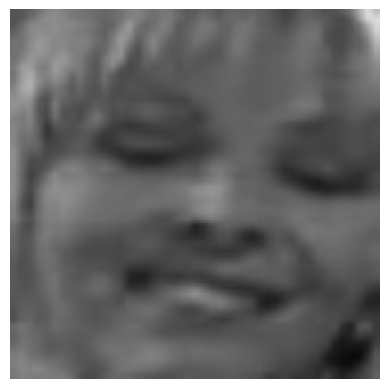

Decoded Text: no [UNK]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
Predicted Image Emotion: joy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
Predicted Text Emotion: joy
True Emotion: joy


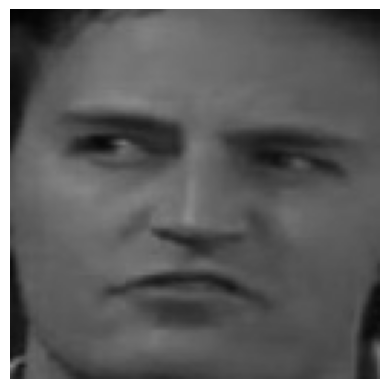

Decoded Text: is that why you became a chef so that people would like you
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted Image Emotion: sadness
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Text Emotion: joy
True Emotion: surprise


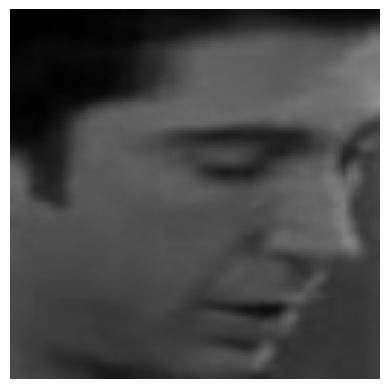

Decoded Text: ok [UNK] uses [UNK] here to highlight the anguish of the central figure touch it its really [UNK]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted Image Emotion: anger
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted Text Emotion: joy
True Emotion: neutral


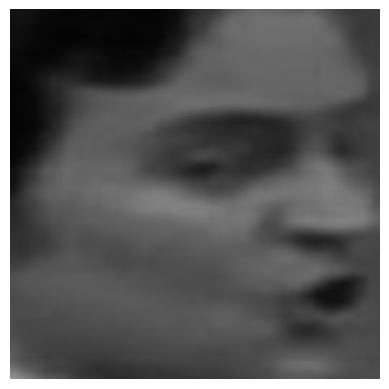

Decoded Text: oh come on guys [UNK] not like i moved to europe i just moved across the hall and
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted Image Emotion: anger
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted Text Emotion: joy
True Emotion: joy


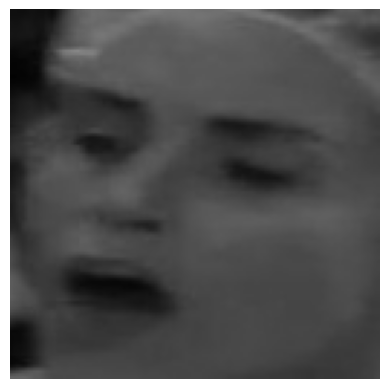

Decoded Text: [UNK] what the hell were you doing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted Image Emotion: sadness
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Text Emotion: joy
True Emotion: disgust


In [13]:
for element in train_val_multimodal_dataset.take(5):
    # Extract images, texts, and labels from the dataset
    image_tensor = element[0][0]  # Image batch
    text_tensor = element[0][1]   # Text batch
    label_tensor = element[1]     # Label batch (one-hot encoded)

    # Display the first image in the batch
    random_image = image_tensor[0].numpy().astype("uint8")  # Take the first image in the batch
    plt.imshow(random_image)
    plt.axis("off")
    plt.show()

    # Decode the first text in the batch
    random_text = text_tensor[0].numpy()  # Take the first text in the batch
    inverse_vocab = {idx: word for idx, word in enumerate(VECTORIZER.get_vocabulary())}  
    decoded_text = " ".join([inverse_vocab.get(i, "") for i in random_text if i > 0]) 
    print("Decoded Text:", decoded_text)

    # Predict emotion from the image
    image_prediction = image_model.predict(random_image[np.newaxis, ...])[0]  
    image_emotion_label = np.argmax(image_prediction)
    image_emotion_name = list(EMOTION_MAP.keys())[image_emotion_label]
    print("Predicted Image Emotion:", image_emotion_name)

    # Predict emotion from the text
    text_prediction = text_model.predict(random_text[np.newaxis, :])[0]  
    text_emotion_label = np.argmax(text_prediction)
    text_emotion_name = list(EMOTION_MAP.keys())[text_emotion_label]
    print("Predicted Text Emotion:", text_emotion_name)

    # Decode the true emotion from the label tensor
    true_emotion_label = np.argmax(label_tensor[0].numpy())  
    true_emotion_name = list(EMOTION_MAP.keys())[true_emotion_label]
    print("True Emotion:", true_emotion_name)


## Training Multimodal Model

In [ ]:
multimodal_model.compile(optimizer=Adam(LEARNING_RATE_MULTIMODAL), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, verbose=True)

multimodal_model.fit(train_multimodal_dataset, epochs=NUM_EPOCHS_MULTIMODAL, validation_data=val_multimodal_dataset, verbose=1, callbacks=[early_stopping])

## Save the Multimodal Model

In [ ]:
multimodal_model.save('multimodal_model.keras')

## Load the Multimodal Model

In [23]:
multimodal_model = tf.keras.models.load_model('Trained Models/Multimodal/newest_multimodal_model.keras')

## Test the model on a random image and text

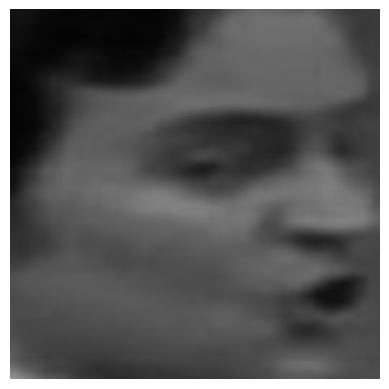

Decoded Text: oh come on guys [UNK] not like i moved to europe i just moved across the hall and
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted Image Emotion: anger
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted Text Emotion: joy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predicted Multimodal Emotion: disgust
True Emotion: joy


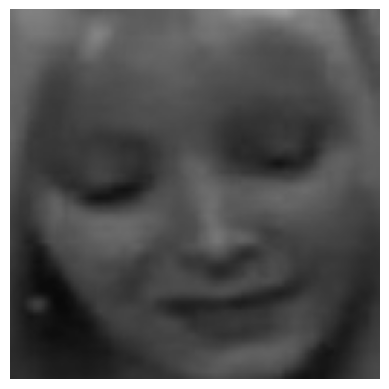

Decoded Text: yep
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted Image Emotion: neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted Text Emotion: joy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted Multimodal Emotion: neutral
True Emotion: joy


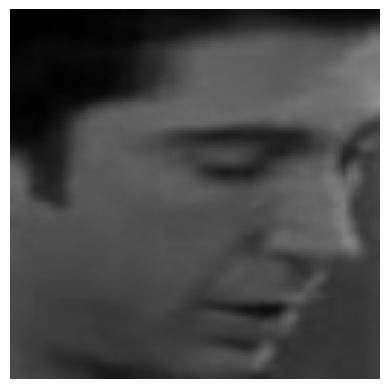

Decoded Text: ok [UNK] uses [UNK] here to highlight the anguish of the central figure touch it its really [UNK]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Predicted Image Emotion: anger
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted Text Emotion: joy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted Multimodal Emotion: disgust
True Emotion: neutral


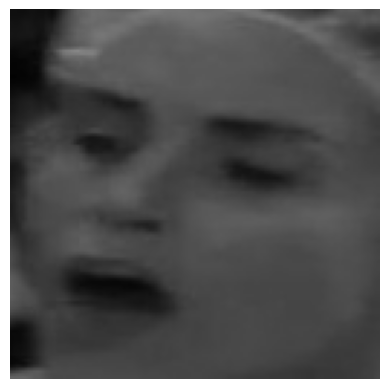

Decoded Text: [UNK] what the hell were you doing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted Image Emotion: sadness
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted Text Emotion: joy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted Multimodal Emotion: disgust
True Emotion: disgust


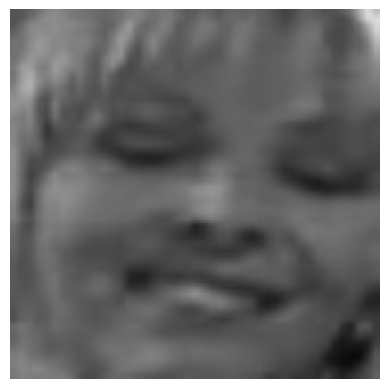

Decoded Text: no [UNK]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted Image Emotion: joy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Text Emotion: joy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted Multimodal Emotion: disgust
True Emotion: joy


In [16]:
for element in train_val_multimodal_dataset.take(5):
    # Extract images, texts, and labels from the dataset
    image_tensor = element[0][0]  # Image batch
    text_tensor = element[0][1]   # Text batch
    label_tensor = element[1]     # Label batch (one-hot encoded)

    # Display the first image in the batch
    random_image = image_tensor[0].numpy().astype("uint8")  # Take the first image in the batch
    plt.imshow(random_image)
    plt.axis("off")
    plt.show()

    # Decode the first text in the batch
    random_text = text_tensor[0].numpy()  # Take the first text in the batch
    inverse_vocab = {idx: word for idx, word in enumerate(VECTORIZER.get_vocabulary())}  
    decoded_text = " ".join([inverse_vocab.get(i, "") for i in random_text if i > 0]) 
    print("Decoded Text:", decoded_text)

    # Predict emotion from the image
    image_prediction = image_model.predict(random_image[np.newaxis, ...])[0]  
    image_emotion_label = np.argmax(image_prediction)
    image_emotion_name = list(EMOTION_MAP.keys())[image_emotion_label]
    print("Predicted Image Emotion:", image_emotion_name)

    # Predict emotion from the text
    text_prediction = text_model.predict(random_text[np.newaxis, :])[0]  
    text_emotion_label = np.argmax(text_prediction)
    text_emotion_name = list(EMOTION_MAP.keys())[text_emotion_label]
    print("Predicted Text Emotion:", text_emotion_name)
    
    #Predict emotion from text and image
    multimodal_prediction = multimodal_model.predict((random_image[np.newaxis, ...], random_text[np.newaxis, :]))[0]
    multimodal_emotion_label = np.argmax(multimodal_prediction)
    multimodal_emotion_name = list(EMOTION_MAP.keys())[multimodal_emotion_label]
    print("Predicted Multimodal Emotion:", multimodal_emotion_name)

    # Decode the true emotion from the label tensor
    true_emotion_label = np.argmax(label_tensor[0].numpy())  
    true_emotion_name = list(EMOTION_MAP.keys())[true_emotion_label]
    print("True Emotion:", true_emotion_name)


## Test text model on multimodal dataset

In [21]:
# Remap the dataset to extract text data and labels
text_dataset = create_text_dataset(TRAIN_VAL_MULTIMODAL_CSV, "Utterance", "Emotion", MAX_WORDS, MAX_SEQUENCE_LENGTH, NUM_CLASSES, BATCH_SIZE_MULTIMODAL)


loss, accuracy = text_model.evaluate(text_dataset, verbose=1)


Labels: [4, 4, 4, 6, 4, 4, 4, 4, 4, 5, 4, 6, 4, 6, 2, 6, 5, 4, 4, 4]
Number of samples in text dataset: 8
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 403ms/step - accuracy: 0.1586 - loss: 2.3012


## Test image model on multimodal dataset

## Test multimodal model on multimodal dataset

In [26]:
loss, accuracy = multimodal_model.evaluate(test_multimodal, verbose=1)

C:\Users\cojuc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['image_model_input', 'text_model_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(
C:\Users\cojuc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 317s 150s/step - accuracy: 0.2333 - loss: 1.9908
